# Notebook with machine learning experiments, trying out TSLearn and SKTime python modlues

## Utility Functions

In [6]:
import time
import pandas as pd
import numpy as np
from os.path import exists
from os import makedirs
from datetime import datetime
from sklearn.metrics import classification_report
from sktime.datatypes._panel._convert import (
    from_multi_index_to_nested,
)
entry_directory = "Raw"
prepared_directory = "Prepared"
organised_directory = "Organised"
ml_directory = "MachineLearning"
RESULTS_PATH = "MachineLearning/results"
DATA_PATH = "MachineLearning/ts_datasets"
seed = 42

def remap_labels(label):
    """Remap labels from string to numeric

    Args:
        label string: label to remap

    Returns:
        int: return number for each label:
            0 - aggregation
            1 - filtration
            2 - filtration-aggregation
            3 - filtration-aggregation-join
            4 - flitration-join
    """
    if label == "aggregation":
        return 0
    elif label == "filtration":
        return 1
    elif label == "filtration-aggregation":
        return 2
    elif label == "filtration-aggregation-join":
        return 3
    else:
        return 4

def grow_snapshots(snapshot, label, snapshots):
    """Grow snapshot numbers incrementally for joined dataframe.

    Args:
        snapshot int: original snapshot number
        label string: label of the snapshot
        snapshots int: number of snapshots in each class.

    Returns:
        int: increased snapshot.
    """
    if label == "aggregation":
        return snapshot
    elif label == "filtration":
        return snapshot + snapshots
    elif label == "filtration-aggregation":
        return snapshot + 2*snapshots
    elif label == "filtration-aggregation-join":
        return snapshot + 3*snapshots
    else:
        return snapshot + 4*snapshots

def read_dataset_TSLearn(udf_types, organised_directory, num_of_samples = 0, include_RAM = False, file_type = "joined"):
    """Reads csv files and converts them into TSLearn friendly format.

    Args:
        udf_types array: requested udf types
        organised_directory string: path to organised directory
        num_of_samples (int, optional): How many samples to read from csvs. Defaults to 0 if all snapshots are to be read.
        include_RAM (bool, optional): Shold RAM dimension be included in the dataset. Defaults to False.
        file_type (str, optional): Type of dataset. Defaults to "joined".

    Returns:
        typle(numpy.array, pandas.dataframe): label array in order, pandas dataframe in tslearn format of CPU and RAM.
    """
    from tslearn.utils import to_time_series_dataset, to_time_series

    full_df = pd.DataFrame()
    for udf_type in udf_types:
        full_df = pd.concat([full_df, pd.read_csv(f"{organised_directory}/{udf_type}/{file_type}_{udf_type}.csv")])
    if num_of_samples > 0:
        full_df = full_df[full_df.snapshot < num_of_samples]
    
    if include_RAM:
        full_df["timeseries"] = full_df.apply(lambda x: np.array([x.CPU, x.RAM]), axis=1)
        full_df = full_df[full_df.snapshot < 200].groupby(["label", "snapshot"]).timeseries.apply(list).reset_index()
        ts_series = full_df.timeseries.apply(to_time_series).to_numpy()
    else:
        full_df = full_df.groupby(["label", "snapshot"]).CPU.apply(np.array).reset_index()
        ts_series = full_df.CPU.to_numpy()
    ts_labels_str = full_df.label.to_numpy()
    ts_labels = full_df.label.apply(remap_labels).to_numpy()
    ts_series = to_time_series_dataset(ts_series)

    return ts_labels, ts_series

def read_dataset_sktime_zeros(udf_types, organised_directory, num_of_samples = 0, include_RAM = False, file_type = "joined"):
    """Reads csv files and converts them into SKTime friendly format padded with zeros.  

    Args:
        udf_types array: requested udf types
        organised_directory string: path to organised directory
        num_of_samples (int, optional): How many samples to read from csvs. Defaults to 0 if all snapshots are to be read.
        include_RAM (bool, optional): Shold RAM dimension be included in the dataset. Defaults to False.
        file_type (str, optional): Type of dataset. Defaults to "joined".

    Returns:
        typle(numpy.array, pandas.dataframe): label array in order, pandas dataframe in tslearn format of CPU and RAM.
    """
    full_df = pd.DataFrame()
    for udf_type in udf_types:
        full_df = pd.concat([full_df, pd.read_csv(f"{organised_directory}/{udf_type}/{file_type}_{udf_type}.csv")])
    if num_of_samples > 0:
        full_df = full_df[full_df.snapshot < num_of_samples]

    ts_y = full_df[full_df.epoch == 0.0].label.apply(remap_labels).to_numpy()
    full_df["snapshot"] = full_df.apply(lambda x: grow_snapshots(x.snapshot, x.label, num_of_samples), axis=1)
    df = full_df.set_index(["snapshot", full_df.groupby("snapshot").cumcount()])
    index = pd.MultiIndex.from_product(df.index.levels, names=df.index.names)
    output = df.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()
    output["row_number"] = output.groupby("snapshot").cumcount()
    if include_RAM:
        ts_x = output[["snapshot", "row_number", "CPU", "RAM"]].set_index(["snapshot", "row_number"])
    else:
        ts_x = output[["snapshot", "row_number", "CPU"]].set_index(["snapshot", "row_number"])

    return ts_y, from_multi_index_to_nested(ts_x)

def wrap_classification_timer(clf, X_train, y_train, x_test, y_test):
    """Wraps classification process in a simple timer

    Args:
        clf : classificator from sklearn library
        X_train pandas.dataframe: X for train dataset
        y_train numpy.array: y for train dataset
        x_test pandas.dataframe: X for test dataset
        y_test numpy.array: y for test dataset

    Returns:
        sklearn classificator after learning.
    """
    start = time.time()
    print(f"start time: {datetime.fromtimestamp(start)}")
    clf.fit(X_train, y_train)
    print(classification_report(y_test, clf.predict(x_test)))
    end = time.time()
    print(f"end time: {datetime.fromtimestamp(end)}")
    time_elapsed = (end - start)/60
    print(f"time elapsed: {time_elapsed} minutes.")

    return clf

def write_ts_file(base_path, dataset_name, possible_labels, X_train, X_test, y_train, y_test):
    """Writes file in ts format that is easy to read for tslearn library.

    Args:
        base_path string: base path for the dataset files
        dataset_name string: name of the dataset
        possible_labels string: list of possible labels delimited with space
        X_train pandas.dataframe: X for train dataset
        X_test pandas.dataframe: X for test dataset
        y_train numpy.array: y for train dataset
        y_test numpy.array: y for test dataset
    """
    if not exists(f"{base_path}/{dataset_name}"):
        makedirs(f"{base_path}/{dataset_name}")
    text_file = open(f"{base_path}/{dataset_name}/{dataset_name}_TRAIN.ts", "w")
    header = f"@problemName {dataset_name}\n@timeStamps false\n@classLabel true {possible_labels}\n@univariate false\n@data\n"
    text_file.write(header)
    i = 0
    for _, dataset in X_train.iterrows():
        ram = ','.join(str(e) for e in dataset.RAM.to_list())
        cpu = ','.join(str(e) for e in dataset.CPU.to_list())
        label = y_train[i]
        i += 1
        output = cpu + ':' + ram + ':' + str(label) + "\n"
        text_file.write(output)
    text_file.close()

    text_file = open(f"{base_path}/{dataset_name}/{dataset_name}_TEST.ts", "w")
    text_file.write(header)
    i = 0
    for _, dataset in X_test.iterrows():
        ram = ','.join(str(e) for e in dataset.RAM.to_list())
        cpu = ','.join(str(e) for e in dataset.CPU.to_list())
        label = y_test[i]
        i += 1
        output = cpu + ':' + ram + ':' + str(label) + "\n"
        text_file.write(output)
    text_file.close()

# TSLearn experiments

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
udf_types = ['aggregation', 'filtration', 'filtration-aggregation']
number_of_samples = 300

joined_ts_labels, joined_ts_series, joined_ts_labels_str = read_dataset_TSLearn(udf_types, organised_directory, number_of_samples, True, "joined")
normalized_ts_labels, normalized_ts_series, normalized_ts_labels_str = read_dataset_TSLearn(udf_types, organised_directory, number_of_samples, True, "normalized")
smooth_ts_labels, smooth_ts_series, smooth_ts_labels_str = read_dataset_TSLearn(udf_types, organised_directory, number_of_samples, True, "12_normalized_smooth")

joined_X_train, joined_X_test, joined_y_train, joined_y_test = train_test_split(joined_ts_series, joined_ts_labels, test_size=0.33, random_state=seed)
normalized_X_train, normalized_X_test, normalized_y_train, normalized_y_test = train_test_split(normalized_ts_series, normalized_ts_labels, test_size=0.33, random_state=seed)
smooth_X_train, smooth_X_test, smooth_y_train, smooth_y_test = train_test_split(smooth_ts_series, smooth_ts_labels, test_size=0.33, random_state=seed)


## KNN

In [34]:

from tslearn.neighbors import KNeighborsTimeSeriesClassifier

# joined dataset
path_to_model = f"./{ml_directory}/knn_trained_joined.hdf5"
if exists(path_to_model):
    knn_joined = KNeighborsTimeSeriesClassifier.from_hdf5(path_to_model)
    print(classification_report(joined_y_test, knn_joined.predict(joined_X_test)))
else:
    knn_joined = wrap_classification_timer(KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw", n_jobs=4), joined_X_train, joined_y_train, joined_X_test, joined_y_test)
    knn_joined.to_hdf5(path_to_model)

start time: 2022-04-30 13:45:37.624882
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.98      1.00      0.99        61
           2       0.94      0.97      0.96        66

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198

end time: 2022-04-30 14:01:01.625050
time elapsed: 15.400002797444662 minutes.


In [35]:
# normalized dataset
path_to_model = f"./{ml_directory}/knn_trained_normalized.hdf5"
if exists(path_to_model):
    knn_normalized = KNeighborsTimeSeriesClassifier.from_hdf5(path_to_model)
    print(classification_report(normalized_y_test, knn_normalized.predict(normalized_X_test)))
else:
    knn_normalized = wrap_classification_timer(KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw", n_jobs=4), normalized_X_train, normalized_y_train, normalized_X_test, normalized_y_test)
    knn_normalized.to_hdf5(path_to_model)


start time: 2022-04-30 14:01:01.741091
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        71
           1       0.98      1.00      0.99        61
           2       0.95      0.92      0.94        66

    accuracy                           0.96       198
   macro avg       0.96      0.96      0.96       198
weighted avg       0.96      0.96      0.96       198

end time: 2022-04-30 14:16:18.656087
time elapsed: 15.281916602452595 minutes.


In [36]:
# smooth dataset
path_to_model = f"./{ml_directory}/knn_trained_smooth.hdf5"
if exists(path_to_model):
    knn_smooth = KNeighborsTimeSeriesClassifier.from_hdf5(path_to_model)
    print(classification_report(smooth_y_test, knn_smooth.predict(smooth_X_test)))
else:
    knn_smooth = wrap_classification_timer(KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw", n_jobs=4), smooth_X_train, smooth_y_train, smooth_X_test, smooth_y_test)
    knn_smooth.to_hdf5(path_to_model)


start time: 2022-04-30 14:16:18.745089
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        71
           1       0.98      1.00      0.99        61
           2       0.92      0.86      0.89        66

    accuracy                           0.93       198
   macro avg       0.93      0.93      0.93       198
weighted avg       0.93      0.93      0.93       198

end time: 2022-04-30 14:31:28.770088
time elapsed: 15.167083323001862 minutes.


## Shapelets

In [44]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tensorflow import optimizers as opt

path_to_model = f"./{ml_directory}/shp_trained_joined.hdf5"
if exists(path_to_model):
    shp_joined = LearningShapelets.from_hdf5(path_to_model)
    print(classification_report(joined_y_test, shp_joined.predict(joined_X_test)))
else:
    n_ts, ts_sz = joined_X_train.shape[:2]
    n_classes = len(set(joined_y_train))
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                        ts_sz=ts_sz,
                                                        n_classes=n_classes,
                                                        l=0.06,
                                                        r=1)
    shp_joined = wrap_classification_timer(LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=opt.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=seed,
                            verbose=0), joined_X_train, joined_y_train, joined_X_test, joined_y_test)



C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.


start time: 2022-04-30 14:41:35.713545
              precision    recall  f1-score   support

           0       0.36      1.00      0.53        71
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        66

    accuracy                           0.36       198
   macro avg       0.12      0.33      0.18       198
weighted avg       0.13      0.36      0.19       198

end time: 2022-04-30 14:47:08.344848
time elapsed: 5.543855047225952 minutes.


C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [45]:
path_to_model = f"./{ml_directory}/shp_trained_normalized.hdf5"
if exists(path_to_model):
    shp_normalized = LearningShapelets.from_hdf5(path_to_model)
    print(classification_report(normalized_y_test, shp_normalized.predict(normalized_X_test)))
else:
    n_ts, ts_sz = normalized_X_train.shape[:2]
    n_classes = len(set(normalized_y_train))
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                        ts_sz=ts_sz,
                                                        n_classes=n_classes,
                                                        l=0.06,
                                                        r=1)
    shp_normalized = wrap_classification_timer(LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=opt.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=seed,
                            verbose=0), normalized_X_train, normalized_y_train, normalized_X_test, normalized_y_test)
    # shp_normalized.to_hdf5(path_to_model)


C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.


start time: 2022-04-30 14:47:08.467856
              precision    recall  f1-score   support

           0       0.36      1.00      0.53        71
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        66

    accuracy                           0.36       198
   macro avg       0.12      0.33      0.18       198
weighted avg       0.13      0.36      0.19       198

end time: 2022-04-30 14:53:23.806428
time elapsed: 6.2556428670883175 minutes.


C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [46]:
path_to_model = f"./{ml_directory}/shp_trained_smooth.hdf5"
if exists(path_to_model):
    shp_smooth = LearningShapelets.from_hdf5(path_to_model)
    print(classification_report(smooth_y_test, shp_smooth.predict(smooth_X_test)))
else:
    n_ts, ts_sz = smooth_X_train.shape[:2]
    n_classes = len(set(smooth_y_train))
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                        ts_sz=ts_sz,
                                                        n_classes=n_classes,
                                                        l=0.06,
                                                        r=1)
    shp_smooth = wrap_classification_timer(LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=opt.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=seed,
                            verbose=0), smooth_X_train, smooth_y_train, smooth_X_test, smooth_y_test)
    # shp_smooth.to_hdf5(path_to_model)


C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.


start time: 2022-04-30 14:53:23.887428
              precision    recall  f1-score   support

           0       0.36      1.00      0.53        71
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        66

    accuracy                           0.36       198
   macro avg       0.12      0.33      0.18       198
weighted avg       0.13      0.36      0.19       198

end time: 2022-04-30 14:59:10.185378
time elapsed: 5.77163249651591 minutes.


C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Miket\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## KMeans

In [47]:
from tslearn.clustering import TimeSeriesKMeans

# joined dataset
path_to_model = f"./{ml_directory}/km_trained_joined.hdf5"
if exists(path_to_model):
    km_joined = TimeSeriesKMeans.from_hdf5(path_to_model)
    print(classification_report(joined_y_test, km_joined.predict(joined_X_test)))
else:
    km_joined = wrap_classification_timer(TimeSeriesKMeans(n_clusters=3, metric="dtw", n_jobs=4, random_state = seed, max_iter_barycenter=5), joined_X_train, joined_y_train, joined_X_test, joined_y_test)
    km_joined.to_hdf5(path_to_model)


start time: 2022-04-30 14:59:10.283377
              precision    recall  f1-score   support

           0       1.00      0.01      0.03        71
           1       1.00      0.08      0.15        61
           2       0.34      1.00      0.51        66

    accuracy                           0.36       198
   macro avg       0.78      0.37      0.23       198
weighted avg       0.78      0.36      0.23       198

end time: 2022-04-30 15:21:10.238334
time elapsed: 21.99924928744634 minutes.


In [8]:
from tslearn.clustering import TimeSeriesKMeans
# normalized dataset
path_to_model = f"./{ml_directory}/km_trained_normalized.hdf5"
if exists(path_to_model):
    km_normalized = TimeSeriesKMeans.from_hdf5(path_to_model)
    print(classification_report(normalized_y_test, km_normalized.predict(normalized_X_test)))
else:
    km_normalized = wrap_classification_timer(TimeSeriesKMeans(n_clusters=3, metric="dtw", n_jobs=4, random_state = seed, max_iter_barycenter=5), normalized_X_train, normalized_y_train, normalized_X_test, normalized_y_test)
    km_normalized.to_hdf5(path_to_model)


              precision    recall  f1-score   support

           0       0.43      0.31      0.36        71
           1       0.53      0.13      0.21        61
           2       0.44      0.88      0.59        66

    accuracy                           0.44       198
   macro avg       0.47      0.44      0.39       198
weighted avg       0.47      0.44      0.39       198



In [ ]:
# smooth dataset
path_to_model = f"./{ml_directory}/km_trained_smooth.hdf5"
if exists(path_to_model):
    km_smooth = TimeSeriesKMeans.from_hdf5(path_to_model)
    print(classification_report(smooth_y_test, km_smooth.predict(smooth_X_test)))
else:
    km_smooth = wrap_classification_timer(TimeSeriesKMeans(n_clusters=3, metric="dtw", n_jobs=4, random_state = seed, max_iter_barycenter=5), smooth_X_train, smooth_y_train, smooth_X_test, smooth_y_test)
    km_smooth.to_hdf5(path_to_model)

# SKTime experiments

In [7]:
from sklearn.model_selection import train_test_split

udf_types = ['aggregation', 'filtration', 'filtration-aggregation']
number_of_samples = 300
joined_sk_labels, joined_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "joined")
normalized_sk_labels, normalized_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "normalized")
smooth_sk_labels, smooth_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "12_normalized_smooth")

joined_X_train, joined_X_test, joined_y_train, joined_y_test = train_test_split(joined_sk_series, joined_sk_labels, test_size=0.33, random_state=seed)
normalized_X_train, normalized_X_test, normalized_y_train, normalized_y_test = train_test_split(normalized_sk_series, normalized_sk_labels, test_size=0.33, random_state=seed)
smooth_X_train, smooth_X_test, smooth_y_train, smooth_y_test = train_test_split(smooth_sk_series, smooth_sk_labels, test_size=0.33, random_state=seed)

## Rocket

In [3]:
from sktime.classification.kernel_based import RocketClassifier

rocket = wrap_classification_timer(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), joined_X_train, joined_y_train, joined_X_test, joined_y_test)

start time: 2022-05-04 14:56:26.150203
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        94
           1       1.00      0.99      1.00       117
           2       1.00      0.97      0.98        86

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297

end time: 2022-05-04 14:59:10.370637
time elapsed: 2.737007224559784 minutes.


In [14]:

rocket = wrap_classification_timer(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), joined_X_train, joined_y_train, joined_X_test, joined_y_test)

start time: 2022-05-16 19:30:17.444951
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        94
           1       1.00      1.00      1.00       117
           2       0.99      0.98      0.98        86

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297

end time: 2022-05-16 19:30:58.554698
time elapsed: 0.6851624449094137 minutes.


In [15]:
rocket = wrap_classification_timer(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), normalized_X_train, normalized_y_train, normalized_X_test, normalized_y_test)

start time: 2022-05-16 19:30:58.641702
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        94
           1       1.00      1.00      1.00       117
           2       0.97      0.98      0.97        86

    accuracy                           0.98       297
   macro avg       0.98      0.98      0.98       297
weighted avg       0.98      0.98      0.98       297

end time: 2022-05-16 19:31:36.592855
time elapsed: 0.6325192054112753 minutes.


In [16]:
rocket = wrap_classification_timer(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), smooth_X_train, smooth_y_train, smooth_X_test, smooth_y_test)

start time: 2022-05-16 19:31:36.728854
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        94
           1       1.00      0.99      1.00       117
           2       0.98      0.98      0.98        86

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297

end time: 2022-05-16 19:32:14.072307
time elapsed: 0.622390882174174 minutes.


### More classes

In [23]:
from sklearn.model_selection import train_test_split

udf_types = ['aggregation', 'filtration', 'filtration-aggregation', 'filtration-aggregation-join', 'filtration-join']
number_of_samples = 300
joined_sk_labels, joined_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "joined")
normalized_sk_labels, normalized_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "normalized")
smooth_sk_labels, smooth_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "12_normalized_smooth")

joined_X_train, joined_X_test, joined_y_train, joined_y_test = train_test_split(joined_sk_series, joined_sk_labels, test_size=0.33, random_state=seed)
normalized_X_train, normalized_X_test, normalized_y_train, normalized_y_test = train_test_split(normalized_sk_series, normalized_sk_labels, test_size=0.33, random_state=seed)
smooth_X_train, smooth_X_test, smooth_y_train, smooth_y_test = train_test_split(smooth_sk_series, smooth_sk_labels, test_size=0.33, random_state=seed)

In [7]:
rocket = wrap_classification_timer(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), joined_X_train, joined_y_train, joined_X_test, joined_y_test)

start time: 2022-05-07 11:31:03.962736
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        92
           1       1.00      1.00      1.00       103
           2       0.98      0.99      0.98        88
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00        98

    accuracy                           0.99       495
   macro avg       0.99      0.99      0.99       495
weighted avg       0.99      0.99      0.99       495

end time: 2022-05-07 11:33:22.580651
time elapsed: 2.3102985898653667 minutes.


In [5]:
rocket = wrap_classification_timer(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), normalized_X_train, normalized_y_train, normalized_X_test, normalized_y_test)

start time: 2022-05-07 11:26:18.830970
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        92
           1       1.00      1.00      1.00       103
           2       0.98      0.99      0.98        88
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00        98

    accuracy                           0.99       495
   macro avg       0.99      0.99      0.99       495
weighted avg       0.99      0.99      0.99       495

end time: 2022-05-07 11:28:36.355485
time elapsed: 2.29207524061203 minutes.


In [17]:
rocket = wrap_classification_timer(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), smooth_X_train, smooth_y_train, smooth_X_test, smooth_y_test)

start time: 2022-05-16 19:38:23.971686
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        94
           1       1.00      0.99      1.00       117
           2       0.99      0.97      0.98        86

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297

end time: 2022-05-16 19:39:01.024201
time elapsed: 0.6175419211387634 minutes.


## HIVECOTEV2

In [19]:
from sktime.classification.hybrid import HIVECOTEV2

hive = wrap_classification_timer(HIVECOTEV2(time_limit_in_minutes=2, random_state = seed), joined_X_train, joined_y_train, joined_X_test, joined_y_test)

start time: 2022-05-16 21:00:27.643878
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        94
           1       1.00      1.00      1.00       117
           2       0.88      0.98      0.92        86

    accuracy                           0.95       297
   macro avg       0.95      0.95      0.95       297
weighted avg       0.96      0.95      0.95       297

end time: 2022-05-16 21:07:05.990389
time elapsed: 6.6391085108121235 minutes.


In [8]:
hive = wrap_classification_timer(HIVECOTEV2(time_limit_in_minutes=2, n_jobs = 8, random_state = seed), normalized_X_train, normalized_y_train, normalized_X_test, normalized_y_test)

start time: 2022-05-03 12:24:47.439320
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        94
           1       1.00      1.00      1.00       117
           2       0.94      0.98      0.96        86

    accuracy                           0.98       297
   macro avg       0.97      0.97      0.97       297
weighted avg       0.98      0.98      0.98       297

end time: 2022-05-03 12:32:58.088857
time elapsed: 8.177492296695709 minutes.


In [9]:
hive = wrap_classification_timer(HIVECOTEV2(time_limit_in_minutes=2, n_jobs = 8, random_state = seed), smooth_X_train, smooth_y_train, smooth_X_test, smooth_y_test)

start time: 2022-05-03 12:32:58.231866
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        94
           1       1.00      1.00      1.00       117
           2       0.96      0.95      0.96        86

    accuracy                           0.98       297
   macro avg       0.97      0.97      0.97       297
weighted avg       0.98      0.98      0.98       297

end time: 2022-05-03 12:41:02.038855
time elapsed: 8.063449827829997 minutes.


## DrCIF

In [16]:
from sklearn.pipeline import Pipeline
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import DrCIF

steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", DrCIF(n_estimators=10, n_jobs = 8, random_state = seed)),
]

cif = wrap_classification_timer(Pipeline(steps), joined_X_train, joined_y_train, joined_X_test, joined_y_test)

start time: 2022-05-03 12:56:14.889016
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        94
           1       1.00      1.00      1.00       117
           2       0.99      0.95      0.97        86

    accuracy                           0.98       297
   macro avg       0.98      0.98      0.98       297
weighted avg       0.98      0.98      0.98       297

end time: 2022-05-03 13:19:53.938897
time elapsed: 23.650831345717112 minutes.


In [17]:
cif = wrap_classification_timer(Pipeline(steps), normalized_X_train, normalized_y_train, normalized_X_test, normalized_y_test)

start time: 2022-05-03 13:21:49.250322
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        94
           1       1.00      1.00      1.00       117
           2       0.97      0.97      0.97        86

    accuracy                           0.98       297
   macro avg       0.98      0.98      0.98       297
weighted avg       0.98      0.98      0.98       297

end time: 2022-05-03 13:40:37.700886
time elapsed: 18.807509406407675 minutes.


In [18]:
cif = wrap_classification_timer(Pipeline(steps), smooth_X_train, smooth_y_train, smooth_X_test, smooth_y_test)

start time: 2022-05-03 13:40:37.800889
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        94
           1       1.00      1.00      1.00       117
           2       0.96      0.95      0.96        86

    accuracy                           0.98       297
   macro avg       0.97      0.97      0.97       297
weighted avg       0.98      0.98      0.98       297

end time: 2022-05-03 13:59:39.859255
time elapsed: 19.03430610895157 minutes.


# Benchmark

In [30]:
from sklearn.metrics import accuracy_score
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier as SKTimeKNN
from sktime.benchmarking.data import UEADataset, make_datasets
from sktime.benchmarking.evaluation import Evaluator
from sktime.benchmarking.metrics import PairwiseMetric
from sktime.benchmarking.orchestration import Orchestrator
from sktime.benchmarking.results import HDDResults
from sktime.benchmarking.strategies import TSCStrategy
from sktime.benchmarking.tasks import TSCTask
from sktime.series_as_features.model_selection import PresplitFilesCV

In [2]:
from sklearn.model_selection import train_test_split

udf_types = ['aggregation', 'filtration', 'filtration-aggregation']
number_of_samples = 300
joined_sk_labels, joined_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "joined")
normalized_sk_labels, normalized_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "normalized")
smooth_sk_labels, smooth_sk_series = read_dataset_sktime_zeros(udf_types, organised_directory, number_of_samples, True, "12_normalized_smooth")

joined_X_train, joined_X_test, joined_y_train, joined_y_test = train_test_split(joined_sk_series, joined_sk_labels, test_size=0.33, random_state=seed)
normalized_X_train, normalized_X_test, normalized_y_train, normalized_y_test = train_test_split(normalized_sk_series, normalized_sk_labels, test_size=0.33, random_state=seed)
smooth_X_train, smooth_X_test, smooth_y_train, smooth_y_test = train_test_split(smooth_sk_series, smooth_sk_labels, test_size=0.33, random_state=seed)


In [5]:
possible_labels = "0 1 2 3 4"
datasets = ["joined", "smooth", "norm"]
for dataset in datasets:
    write_ts_file(DATA_PATH, dataset, possible_labels, joined_X_train, joined_X_test, joined_y_train, joined_y_test)

datasets = make_datasets(
    path=DATA_PATH, dataset_cls=UEADataset, names=datasets
)
tasks = [TSCTask(target="target") for _ in range(len(datasets))]

strategies = [
    TSCStrategy(RocketClassifier(rocket_transform="multirocket", random_state = seed, n_jobs = 8), name="rocket_multi"),
    TSCStrategy(RocketClassifier(random_state = seed, n_jobs = 8), name="rocket"),
    TSCStrategy(HIVECOTEV2(time_limit_in_minutes=2, n_jobs = 8, random_state = seed), name="HIVE_2_mintues"),
    TSCStrategy(HIVECOTEV2(time_limit_in_minutes=1, n_jobs = 8, random_state = seed), name="HIVE_1_mintue"),
    TSCStrategy(SKTimeKNN(n_neighbors=3, distance="euclidean", n_jobs = 8, random_state = seed), name="KNNEculidan"),
    TSCStrategy(SKTimeKNN(n_neighbors=3, distance="dtw", n_jobs = 8, random_state = seed), name="KNNDTW")
]
results = HDDResults(path=RESULTS_PATH)

In [17]:
orchestrator = Orchestrator(
    datasets=datasets,
    tasks=tasks,
    strategies=strategies,
    cv=PresplitFilesCV(),
    results=results,
)
orchestrator.fit_predict(save_fitted_strategies=True, overwrite_predictions=True, verbose = True)

strategy: 1/6 - rocket_multi on CV-fold: 0/0 of dataset: 1/3 - joined
strategy: 2/6 - rocket on CV-fold: 0/0 of dataset: 1/3 - joined
strategy: 3/6 - HIVE_2_mintues on CV-fold: 0/0 of dataset: 1/3 - joined
strategy: 4/6 - HIVE_1_mintue on CV-fold: 0/0 of dataset: 1/3 - joined
strategy: 5/6 - KNNEculidan on CV-fold: 0/0 of dataset: 1/3 - joined
strategy: 6/6 - KNNDTW on CV-fold: 0/0 of dataset: 1/3 - joined
strategy: 1/6 - rocket_multi on CV-fold: 0/0 of dataset: 2/3 - smooth
strategy: 2/6 - rocket on CV-fold: 0/0 of dataset: 2/3 - smooth
strategy: 3/6 - HIVE_2_mintues on CV-fold: 0/0 of dataset: 2/3 - smooth
strategy: 4/6 - HIVE_1_mintue on CV-fold: 0/0 of dataset: 2/3 - smooth
strategy: 5/6 - KNNEculidan on CV-fold: 0/0 of dataset: 2/3 - smooth
strategy: 6/6 - KNNDTW on CV-fold: 0/0 of dataset: 2/3 - smooth
strategy: 1/6 - rocket_multi on CV-fold: 0/0 of dataset: 3/3 - norm
strategy: 2/6 - rocket on CV-fold: 0/0 of dataset: 3/3 - norm
strategy: 3/6 - HIVE_2_mintues on CV-fold: 0/0 of 

In [36]:
evaluator = Evaluator(results)
metric = PairwiseMetric(func=accuracy_score, name="accuracy")
metrics_by_strategy = evaluator.evaluate(metric=metric)
metrics_by_strategy.head(6)

,strategy,accuracy_mean,accuracy_stderr
0,HIVE_1_mintue,0.969697,0.009919
1,HIVE_2_mintues,0.971942,0.009521
2,KNNDTW,0.969697,0.009964
3,KNNEculidan,0.909091,0.016709
4,rocket,0.988777,0.006108
5,rocket_multi,0.991021,0.005459


In [24]:
evaluator.rank().sort_values("accuracy_mean_rank")

,strategy,accuracy_mean_rank
5,rocket_multi,1.166667
4,rocket,1.833333
1,HIVE_2_mintues,3.666667
0,HIVE_1_mintue,4.166667
2,KNNDTW,4.166667
3,KNNEculidan,6.000000


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'accuracy by strategy'}, xlabel='strategies', ylabel='accuracy'>)

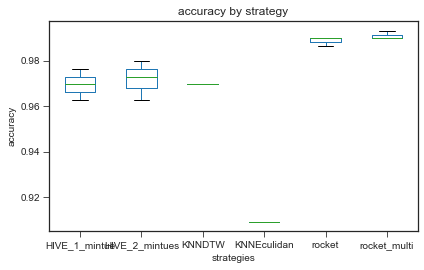

In [19]:
evaluator.plot_boxplots()

In [28]:
evaluator.friedman_test()

(FriedmanchisquareResult(statistic=13.446601941747574, pvalue=0.019534407598811847),
    statistic   p_value
 0  13.446602  0.019534)